# MNIST数据集

MNIST是一个手写数字图像数据集，它由60,000个用于训练的图像和10,000个用于测试的图像组成。每个图像都是28x28像素的灰度图像，表示0到9之间的一个数字。MNIST数据集已成为机器学习领域中最广泛使用的数据集之一，尤其是在图像分类任务中。许多算法和模型都在MNIST上进行了测试和比较，成为了机器学习中的一个基准测试数据集。

下载地址：http://yann.lecun.com/exdb/mnist/

## 1、数据集读取和可视化

In [1]:
%matplotlib inline
import pickle
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
# 十种类别
label_name = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [3]:
# 示例数据集路径
example_path = './dataset/MNIST/train-images.idx3-ubyte'

In [4]:
# 定义读取mnist文件格式
# https://github.com/zalandoresearch/fashion-mnist
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [5]:
# 训练集
img_train, label_train = load_mnist('./dataset/MNIST', kind='train')
# 测试集
img_test, label_test = load_mnist('./dataset/MNIST', kind='t10k')

In [6]:
print(img_train.shape)
print(img_test.shape)

(60000, 784)
(10000, 784)


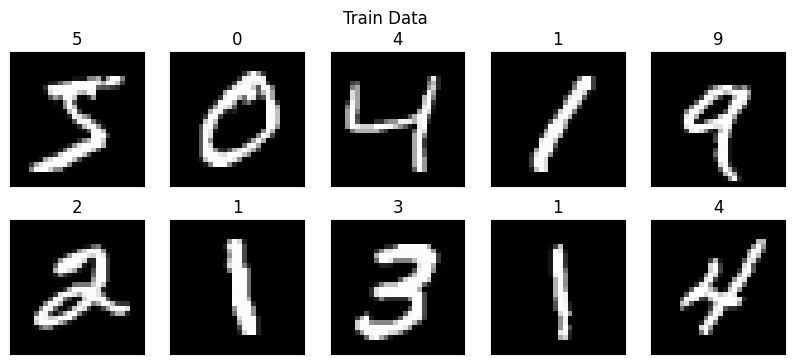

In [7]:
# 可视化前10个图像
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(img_train[i].reshape(28, 28), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(label_name[label_train[i]])
plt.suptitle('Train Data')
plt.show()

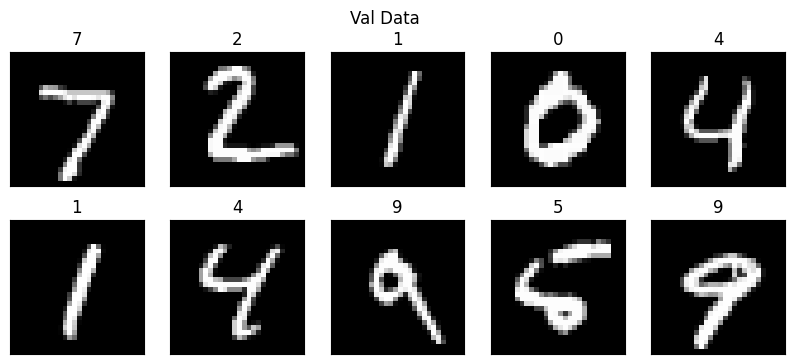

In [8]:
# 可视化前10个图像
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(img_test[i].reshape(28, 28), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(label_name[label_test[i]])
plt.suptitle('Val Data')
plt.show()

## 2、建立dataset

In [9]:
import torch
import torch.utils.data as data
import torchvision.transforms as transforms

In [10]:
# 定义数据集
class MNIST_dataset(data.Dataset):
    def __init__(self, 
                image, 
                label):
        self.image = image
        self.label = label
    
    def __getitem__(self,index):
        img = self.image[index]
        
        img = img.reshape(1, 28, 28)
        
        label = self.label[index]
        images = torch.tensor(img,dtype=torch.float32)
        labels = torch.tensor(label,dtype=torch.long)

        return images, labels
    
    def __len__(self):
        return len(self.image)

In [11]:
train_dataset = MNIST_dataset(
    image = img_train,
    label = label_train
)

test_dataset =  MNIST_dataset(
    image = img_test,
    label = label_test
)

In [12]:
# 定义train_loader
train_loader = data.DataLoader(
    train_dataset, 
    batch_size=256, 
    shuffle=True, 
    num_workers=0
)

# 定义test_loader
test_loader = data.DataLoader(
    test_dataset,
    batch_size=64, 
    shuffle=True, 
    num_workers=0
)

In [13]:
print(len(train_loader))
print(len(test_loader))

235
157


## 3、搭建神经网络

从模型文件中导入模型

In [14]:
import torch.nn as nn

from nn.LeNet import LeNet_1C
from nn.ResNet import ResNet50
from nn.Vision_Transformer import VIT

In [15]:
choice = 'Flag used to choose model'
while choice not in ['0','1','2']:
    choice = input("Choose model in [LeNet, ResNet, VIT] with input of (0 or 1 or 2)")
choice = int(choice)
choice

2

In [16]:
# 定义模型名称和对应的类
model_dict = {
    0: LeNet_1C,
    1: ResNet50,
    2: VIT
}

# 根据choice选择模型类
if choice in model_dict:
    model_class = model_dict[choice]
    if choice < 2:
        model = model_class(class_number=10, in_channels = 1)
    elif choice == 2:
        model = model_class(
            image_size = 28,
            channels = 1,
            patch_size = 4,
            num_classes = 10,
            dim = 64,
            depth = 6,
            heads = 16,
            mlp_dim = 128,
            dropout = 0.1,
            emb_dropout = 0.1
            )
else:
    raise ValueError('Invalid choice of model')
print(f'use model {model_class}')

use model <class 'nn.Vision_Transformer.VIT'>


## 4、训练过程

定义损失函数、优化器，训练模型，保存模型

设置device

In [17]:
# 设置GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


将模型加载到device上

In [18]:
model.to(device)

VIT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
    (1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=16, out_features=64, bias=True)
    (3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0-5): 6 x ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (attend): Softmax(dim=-1)
            (dropout): Dropout(p=0.1, inplace=False)
            (to_qkv): Linear(in_features=64, out_features=3072, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=1024, out_features=64, bias=True)
              (1): Dropout(p=0.1, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)

训练参数

In [19]:
EPOCH = 100
learning_rate = 0.001

# 交叉熵损失函数
criterion = nn.CrossEntropyLoss()

# 优化器
#optimizer = torch.optim.SGD(params=model.parameters(),
#                            lr = learning_rate
#)
# Adam优化器
optimizer = torch.optim.Adam(model.parameters(),
                lr=learning_rate,
)

训练过程

In [20]:
import time
from tqdm import tqdm

In [21]:
# 定义模型名称和对应的文件名
model_file_dict = {
    0: 'LeNet',
    1: 'ResNet50',
    2: 'VIT'
}

# 根据choice选择文件名
if choice in model_file_dict:
    file_name = model_file_dict[choice]
else:
    raise ValueError('Invalid choice of model')

In [22]:
train_loss = []
train_acc = []
val_loss = []
val_acc = []
standered_acc = 0.0

# 将模型设为训练模式
model.train()

def train():
    for epoch in range(EPOCH):
        running_loss = 0.0
        total = 0
        correct = 0
        start_time = time.time()  # 记录训练开始时间
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
        for i, data in progress_bar:
            #取出数据及标签
            inputs,labels = data
            #数据及标签均送入GPU或CPU
            inputs,labels = inputs.to(device),labels.to(device)
            #前向传播
            outputs = model(inputs)
            #计算损失函数
            loss = criterion(outputs,labels)
            running_loss += loss.item()
            #清空上一轮的梯度
            optimizer.zero_grad()
            #反向传播
            loss.backward()
            #参数更新
            optimizer.step()
            # Calculate accuracy
            # 在给定维度上输出张量outputs中的最大值及其对应的索引

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # 计算训练速度和时间
            used_time = time.time() - start_time
            it_per_sec = (i + 1) / (used_time+0.001)
            last_time = used_time / (i + 1) * (len(train_loader) - i - 1)

            # 更新进度条
            progress_bar.set_description(
                f"Epoch{epoch+1}, loss: {loss.item():.4f}, Acc: {100 * correct / total :.2f}%, mem: {torch.cuda.max_memory_allocated() / 1024 / 1024 / 1024:.2f} GB"
            )

        # Validation
        model.eval() # Set model to evaluation mode
        val_running_loss = 0.0
        val_total = 0
        val_correct = 0
        start_time = time.time()  # 记录训练开始时间
        progress_bar = tqdm(enumerate(test_loader), total=len(test_loader))
        with torch.no_grad(): # Disable gradient computation for efficiency
            for i, val_data in progress_bar: # Use test_loader for validation
                val_inputs, val_labels = val_data
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                loss = criterion(val_outputs, val_labels)
                val_running_loss += loss.item()
                _, val_predicted = torch.max(val_outputs.data, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()

                used_time = time.time() - start_time
                it_per_sec = (i + 1) / (used_time+0.001)
                last_time = used_time / (i + 1) * (len(train_loader) - i - 1)

                progress_bar.set_description(
                f"Epoch{epoch+1}_val, loss: {loss.item():.4f}, Acc: {100 * val_correct / val_total :.2f}%, mem: {torch.cuda.max_memory_allocated() / 1024 / 1024 / 1024:.2f} GB"
            )
        
        
        val_loss.append(val_running_loss / len(test_loader))
        val_acc.append(100 * val_correct / val_total)
        standered_acc = max(val_acc)

        # 保存best.pt 
        if val_acc[-1] == standered_acc:
            torch.save(model.state_dict(), f'./checkpoints/MNIST/{file_name}'+'_best.pt')
            print('saved best model to checkpoints/MNIST')
        model.train() # Set model back to training mode

        train_loss.append(running_loss / len(train_loader))
        train_acc.append(100 * correct / total)

In [23]:
train()

Epoch1, loss: 0.1627, Acc: 79.17%, mem: 2.13 GB: 100%|██████████| 235/235 [01:29<00:00,  2.63it/s]
Epoch1_val, loss: 0.3424, Acc: 95.36%, mem: 2.13 GB: 100%|██████████| 157/157 [00:07<00:00, 19.95it/s]


saved best model to checkpoints/MNIST


Epoch2, loss: 0.0991, Acc: 95.50%, mem: 2.13 GB: 100%|██████████| 235/235 [01:24<00:00,  2.80it/s]
Epoch2_val, loss: 0.0399, Acc: 96.92%, mem: 2.13 GB: 100%|██████████| 157/157 [00:07<00:00, 21.55it/s]


saved best model to checkpoints/MNIST


Epoch3, loss: 0.1781, Acc: 96.84%, mem: 2.13 GB: 100%|██████████| 235/235 [01:16<00:00,  3.09it/s]
Epoch3_val, loss: 0.0178, Acc: 97.53%, mem: 2.13 GB: 100%|██████████| 157/157 [00:07<00:00, 21.88it/s]


saved best model to checkpoints/MNIST


Epoch4, loss: 0.0928, Acc: 97.28%, mem: 2.13 GB: 100%|██████████| 235/235 [01:16<00:00,  3.08it/s]
Epoch4_val, loss: 0.1087, Acc: 97.81%, mem: 2.13 GB: 100%|██████████| 157/157 [00:07<00:00, 21.83it/s]


saved best model to checkpoints/MNIST


Epoch5, loss: 0.0869, Acc: 97.77%, mem: 2.13 GB: 100%|██████████| 235/235 [01:15<00:00,  3.10it/s]
Epoch5_val, loss: 0.0235, Acc: 97.98%, mem: 2.13 GB: 100%|██████████| 157/157 [00:07<00:00, 22.07it/s]


saved best model to checkpoints/MNIST


Epoch6, loss: 0.0670, Acc: 97.86%, mem: 2.13 GB: 100%|██████████| 235/235 [01:15<00:00,  3.11it/s]
Epoch6_val, loss: 0.0016, Acc: 98.13%, mem: 2.13 GB: 100%|██████████| 157/157 [00:07<00:00, 22.04it/s]


saved best model to checkpoints/MNIST


Epoch7, loss: 0.0287, Acc: 98.07%, mem: 2.13 GB: 100%|██████████| 235/235 [01:16<00:00,  3.09it/s]
Epoch7_val, loss: 0.0185, Acc: 98.30%, mem: 2.13 GB: 100%|██████████| 157/157 [00:07<00:00, 21.22it/s]


saved best model to checkpoints/MNIST


Epoch8, loss: 0.0271, Acc: 98.12%, mem: 2.13 GB: 100%|██████████| 235/235 [01:15<00:00,  3.09it/s]
Epoch8_val, loss: 0.0012, Acc: 98.17%, mem: 2.13 GB: 100%|██████████| 157/157 [00:07<00:00, 22.15it/s]
Epoch9, loss: 0.0539, Acc: 98.27%, mem: 2.13 GB: 100%|██████████| 235/235 [01:16<00:00,  3.07it/s]
Epoch9_val, loss: 0.0127, Acc: 98.47%, mem: 2.13 GB: 100%|██████████| 157/157 [00:07<00:00, 21.10it/s]


saved best model to checkpoints/MNIST


Epoch10, loss: 0.0628, Acc: 98.41%, mem: 2.13 GB: 100%|██████████| 235/235 [01:15<00:00,  3.10it/s]
Epoch10_val, loss: 0.0104, Acc: 98.14%, mem: 2.13 GB: 100%|██████████| 157/157 [00:07<00:00, 20.48it/s]
Epoch11, loss: 0.1073, Acc: 98.51%, mem: 2.13 GB: 100%|██████████| 235/235 [01:23<00:00,  2.81it/s]
Epoch11_val, loss: 0.1781, Acc: 98.26%, mem: 2.13 GB: 100%|██████████| 157/157 [00:08<00:00, 18.94it/s]
Epoch12, loss: 0.0327, Acc: 98.61%, mem: 2.13 GB: 100%|██████████| 235/235 [01:23<00:00,  2.81it/s]
Epoch12_val, loss: 0.0018, Acc: 98.49%, mem: 2.13 GB: 100%|██████████| 157/157 [00:08<00:00, 19.27it/s]


saved best model to checkpoints/MNIST


Epoch13, loss: 0.0664, Acc: 98.66%, mem: 2.13 GB: 100%|██████████| 235/235 [01:15<00:00,  3.12it/s]
Epoch13_val, loss: 0.0017, Acc: 98.45%, mem: 2.13 GB: 100%|██████████| 157/157 [00:06<00:00, 22.52it/s]
Epoch14, loss: 0.0371, Acc: 98.70%, mem: 2.13 GB: 100%|██████████| 235/235 [01:16<00:00,  3.07it/s]
Epoch14_val, loss: 0.0005, Acc: 98.37%, mem: 2.13 GB: 100%|██████████| 157/157 [00:07<00:00, 22.24it/s]
Epoch15, loss: 0.0437, Acc: 98.81%, mem: 2.13 GB: 100%|██████████| 235/235 [01:16<00:00,  3.07it/s]
Epoch15_val, loss: 0.2201, Acc: 98.31%, mem: 2.13 GB: 100%|██████████| 157/157 [00:06<00:00, 22.55it/s]
Epoch16, loss: 0.0468, Acc: 98.89%, mem: 2.13 GB: 100%|██████████| 235/235 [01:15<00:00,  3.11it/s]
Epoch16_val, loss: 0.0002, Acc: 98.47%, mem: 2.13 GB: 100%|██████████| 157/157 [00:07<00:00, 21.41it/s]
Epoch17, loss: 0.1462, Acc: 98.75%, mem: 2.13 GB: 100%|██████████| 235/235 [01:16<00:00,  3.09it/s]
Epoch17_val, loss: 0.0003, Acc: 98.42%, mem: 2.13 GB: 100%|██████████| 157/157 [00:0

saved best model to checkpoints/MNIST


Epoch19, loss: 0.0716, Acc: 99.04%, mem: 2.13 GB: 100%|██████████| 235/235 [01:15<00:00,  3.11it/s]
Epoch19_val, loss: 0.1100, Acc: 98.16%, mem: 2.13 GB: 100%|██████████| 157/157 [00:07<00:00, 21.67it/s]
Epoch20, loss: 0.0134, Acc: 98.95%, mem: 2.13 GB: 100%|██████████| 235/235 [01:15<00:00,  3.13it/s]
Epoch20_val, loss: 0.0188, Acc: 98.58%, mem: 2.13 GB: 100%|██████████| 157/157 [00:07<00:00, 21.65it/s]


saved best model to checkpoints/MNIST


Epoch21, loss: 0.0104, Acc: 99.09%, mem: 2.13 GB: 100%|██████████| 235/235 [01:16<00:00,  3.09it/s]
Epoch21_val, loss: 0.0006, Acc: 98.61%, mem: 2.13 GB: 100%|██████████| 157/157 [00:06<00:00, 23.39it/s]


saved best model to checkpoints/MNIST


Epoch22, loss: 0.0150, Acc: 98.96%, mem: 2.13 GB: 100%|██████████| 235/235 [01:14<00:00,  3.15it/s]
Epoch22_val, loss: 0.0001, Acc: 98.43%, mem: 2.13 GB: 100%|██████████| 157/157 [00:07<00:00, 22.00it/s]
Epoch23, loss: 0.0037, Acc: 99.13%, mem: 2.13 GB: 100%|██████████| 235/235 [01:15<00:00,  3.13it/s]
Epoch23_val, loss: 0.0726, Acc: 98.32%, mem: 2.13 GB: 100%|██████████| 157/157 [00:07<00:00, 21.73it/s]
Epoch24, loss: 0.0482, Acc: 99.09%, mem: 2.13 GB: 100%|██████████| 235/235 [01:15<00:00,  3.12it/s]
Epoch24_val, loss: 0.0007, Acc: 98.42%, mem: 2.13 GB: 100%|██████████| 157/157 [00:07<00:00, 21.66it/s]
Epoch25, loss: 0.0161, Acc: 99.03%, mem: 2.13 GB: 100%|██████████| 235/235 [01:15<00:00,  3.10it/s]
Epoch25_val, loss: 0.0002, Acc: 98.45%, mem: 2.13 GB: 100%|██████████| 157/157 [00:07<00:00, 22.17it/s]
Epoch26, loss: 0.0822, Acc: 99.13%, mem: 2.13 GB: 100%|██████████| 235/235 [01:15<00:00,  3.13it/s]
Epoch26_val, loss: 0.0228, Acc: 98.49%, mem: 2.13 GB: 100%|██████████| 157/157 [00:0

saved best model to checkpoints/MNIST


Epoch40, loss: 0.0276, Acc: 99.39%, mem: 2.13 GB: 100%|██████████| 235/235 [01:24<00:00,  2.78it/s]
Epoch40_val, loss: 0.0009, Acc: 98.69%, mem: 2.13 GB: 100%|██████████| 157/157 [00:07<00:00, 20.84it/s]


saved best model to checkpoints/MNIST


Epoch41, loss: 0.0027, Acc: 99.33%, mem: 2.13 GB: 100%|██████████| 235/235 [01:24<00:00,  2.78it/s]
Epoch41_val, loss: 0.0034, Acc: 98.78%, mem: 2.13 GB: 100%|██████████| 157/157 [00:07<00:00, 20.32it/s]


saved best model to checkpoints/MNIST


Epoch42, loss: 0.0303, Acc: 99.48%, mem: 2.13 GB: 100%|██████████| 235/235 [01:20<00:00,  2.91it/s]
Epoch42_val, loss: 0.0035, Acc: 98.58%, mem: 2.13 GB: 100%|██████████| 157/157 [00:06<00:00, 22.48it/s]
Epoch43, loss: 0.0290, Acc: 99.38%, mem: 2.13 GB: 100%|██████████| 235/235 [01:16<00:00,  3.08it/s]
Epoch43_val, loss: 0.1286, Acc: 98.55%, mem: 2.13 GB: 100%|██████████| 157/157 [00:07<00:00, 21.51it/s]
Epoch44, loss: 0.0578, Acc: 99.30%, mem: 2.13 GB: 100%|██████████| 235/235 [01:15<00:00,  3.10it/s]
Epoch44_val, loss: 0.0310, Acc: 98.69%, mem: 2.13 GB: 100%|██████████| 157/157 [00:07<00:00, 22.00it/s]
Epoch45, loss: 0.0099, Acc: 99.42%, mem: 2.13 GB: 100%|██████████| 235/235 [01:16<00:00,  3.08it/s]
Epoch45_val, loss: 0.0002, Acc: 98.46%, mem: 2.13 GB: 100%|██████████| 157/157 [00:07<00:00, 22.07it/s]
Epoch46, loss: 0.0058, Acc: 99.46%, mem: 2.13 GB: 100%|██████████| 235/235 [01:15<00:00,  3.10it/s]
Epoch46_val, loss: 0.0002, Acc: 98.60%, mem: 2.13 GB: 100%|██████████| 157/157 [00:0

saved best model to checkpoints/MNIST


Epoch49, loss: 0.0468, Acc: 99.57%, mem: 2.13 GB: 100%|██████████| 235/235 [01:23<00:00,  2.81it/s]
Epoch49_val, loss: 0.0003, Acc: 98.68%, mem: 2.13 GB: 100%|██████████| 157/157 [00:07<00:00, 19.86it/s]
Epoch50, loss: 0.0028, Acc: 99.42%, mem: 2.13 GB: 100%|██████████| 235/235 [01:24<00:00,  2.79it/s]
Epoch50_val, loss: 0.0060, Acc: 98.75%, mem: 2.13 GB: 100%|██████████| 157/157 [00:07<00:00, 20.19it/s]
Epoch51, loss: 0.0029, Acc: 99.58%, mem: 2.13 GB: 100%|██████████| 235/235 [01:23<00:00,  2.81it/s]
Epoch51_val, loss: 0.0076, Acc: 98.76%, mem: 2.13 GB: 100%|██████████| 157/157 [00:07<00:00, 19.89it/s]
Epoch52, loss: 0.0623, Acc: 99.60%, mem: 2.13 GB: 100%|██████████| 235/235 [01:23<00:00,  2.81it/s]
Epoch52_val, loss: 0.0001, Acc: 98.80%, mem: 2.13 GB: 100%|██████████| 157/157 [00:08<00:00, 19.55it/s]
Epoch53, loss: 0.0015, Acc: 99.44%, mem: 2.13 GB: 100%|██████████| 235/235 [01:24<00:00,  2.79it/s]
Epoch53_val, loss: 0.0010, Acc: 98.78%, mem: 2.13 GB: 100%|██████████| 157/157 [00:0

saved best model to checkpoints/MNIST


Epoch68, loss: 0.0191, Acc: 99.64%, mem: 2.13 GB: 100%|██████████| 235/235 [01:24<00:00,  2.78it/s]
Epoch68_val, loss: 0.0908, Acc: 98.88%, mem: 2.13 GB: 100%|██████████| 157/157 [00:07<00:00, 20.29it/s]
Epoch69, loss: 0.0019, Acc: 99.65%, mem: 2.13 GB: 100%|██████████| 235/235 [01:23<00:00,  2.81it/s]
Epoch69_val, loss: 0.0001, Acc: 98.72%, mem: 2.13 GB: 100%|██████████| 157/157 [00:07<00:00, 20.46it/s]
Epoch70, loss: 0.0033, Acc: 99.61%, mem: 2.13 GB: 100%|██████████| 235/235 [01:25<00:00,  2.76it/s]
Epoch70_val, loss: 0.0001, Acc: 98.76%, mem: 2.13 GB: 100%|██████████| 157/157 [00:07<00:00, 19.79it/s]
Epoch71, loss: 0.0002, Acc: 99.53%, mem: 2.13 GB: 100%|██████████| 235/235 [01:23<00:00,  2.81it/s]
Epoch71_val, loss: 0.0046, Acc: 98.86%, mem: 2.13 GB: 100%|██████████| 157/157 [00:07<00:00, 19.91it/s]
Epoch72, loss: 0.0334, Acc: 99.66%, mem: 2.13 GB: 100%|██████████| 235/235 [01:24<00:00,  2.78it/s]
Epoch72_val, loss: 0.0052, Acc: 98.85%, mem: 2.13 GB: 100%|██████████| 157/157 [00:0

## 5、保存模型

将训练结果保存到 `./checkpoints/MNIST/*.pt`

In [24]:
# 保存模型参数
torch.save(model.state_dict(), f'./checkpoints/MNIST/{file_name}'+'_last.pt')

## 6、测试模型

加载保存好的模型，并在测试集上测试准确率、损失、以及保存测试结果

加载模型

In [25]:
if choice < 2: 
    net = model_class(class_number=10, in_channels=1)
elif choice == 2:
    net = model_class(
            image_size = 28,
            channels = 1,
            patch_size = 4,
            num_classes = 10,
            dim = 64,
            depth = 6,
            heads = 16,
            mlp_dim = 128,
            dropout = 0.1,
            emb_dropout = 0.1)
else:
    net = model_class(
        img_size=32, patch_size=2, in_chans=1, num_classes=10,
        embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24],
        window_size=2, mlp_ratio=4., drop_rate=0., drop_path_rate=0.1,
        norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
        use_checkpoint=False
    )

# 加载best.pt
net.load_state_dict(torch.load(f'./checkpoints/MNIST/{file_name}'+'_best.pt'))

net.to(device)

VIT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
    (1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=16, out_features=64, bias=True)
    (3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0-5): 6 x ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (attend): Softmax(dim=-1)
            (dropout): Dropout(p=0.1, inplace=False)
            (to_qkv): Linear(in_features=64, out_features=3072, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=1024, out_features=64, bias=True)
              (1): Dropout(p=0.1, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)

测试模型

In [26]:
# 将模型设置为评估模式
net.eval()

# 用模型对测试集进行推断
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# 输出模型在测试集上的准确率
print('Accuracy of the model on the test images: {:.2f} %' .format(100 * correct / total))

Accuracy of the model on the test images: 98.92 %


## 7、保存结果

保存 train_loss、val_loss、train_acc、val_acc 四幅图像，以及检测结果的png，保存目录为：`./results/MNIST/*/*.png`

In [27]:
x = np.arange(1,EPOCH+1).astype(dtype=str)
x

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45',
       '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56',
       '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67',
       '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78',
       '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89',
       '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100'],
      dtype='<U11')

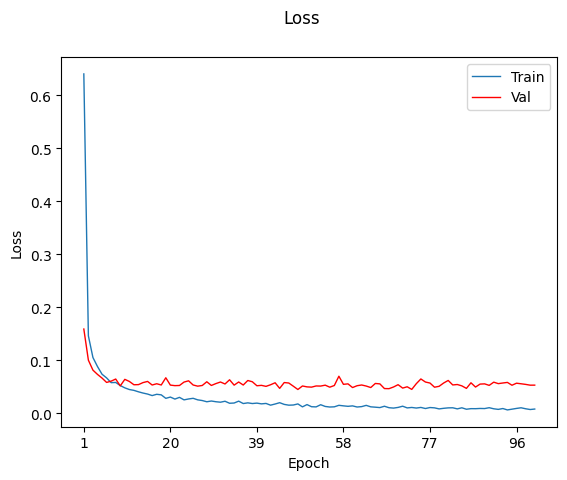

In [29]:
plt.plot(x,train_loss, label='Train', linewidth=1)
plt.plot(x,val_loss, label='Val', color='red', linewidth=1)
plt.xticks(np.arange(0, 101, 19))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.suptitle("Loss")
plt.savefig("./results/MNIST/{}/Loss.png".format(file_name))
plt.show()

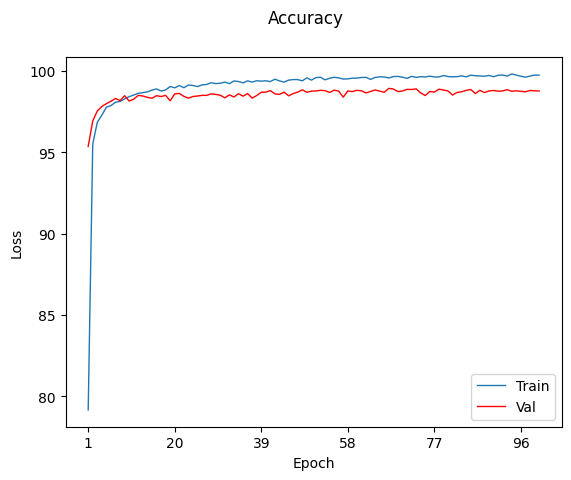

In [30]:
plt.plot(x,train_acc, label='Train', linewidth=1)
plt.plot(x,val_acc, label = 'Val' , color='red', linewidth=1)
plt.xticks(np.arange(0, 101, 19))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.suptitle('Accuracy')
plt.savefig('./results/MNIST/{}/ACC.png'.format(file_name))
plt.show()

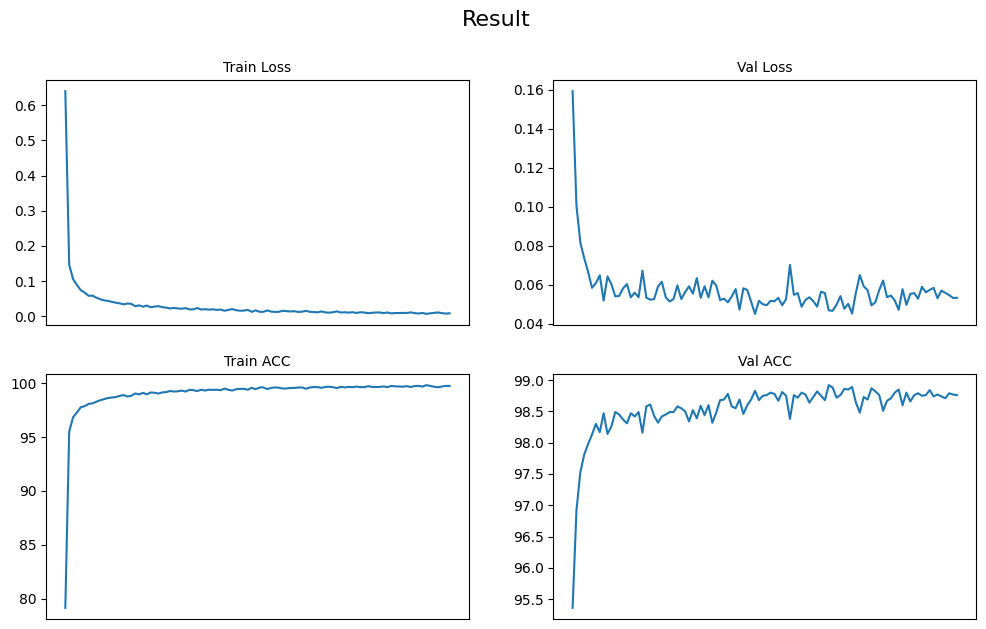

In [31]:
# 可视化前10个图像
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))

ax1 = axes.flat[0]
ax1.plot(train_loss)
ax1.set_title('Train Loss',fontsize=10)
ax1.set_xticks([])

ax2 = axes.flat[1]
ax2.plot(val_loss)
ax2.set_title('Val Loss', fontsize=10)
ax2.set_xticks([])

ax3 = axes.flat[2]
ax3.plot(train_acc)
ax3.set_title('Train ACC', fontsize=10)
ax3.set_xticks([])

ax4 = axes.flat[3]
ax4.plot(val_acc)
ax4.set_title('Val ACC', fontsize=10)
ax4.set_xticks([])

plt.suptitle("Result", fontsize=16)
plt.savefig('./results/MNIST/{}/Result.png'.format(file_name))
plt.show()

# 保存模型的预测结果与原始图像

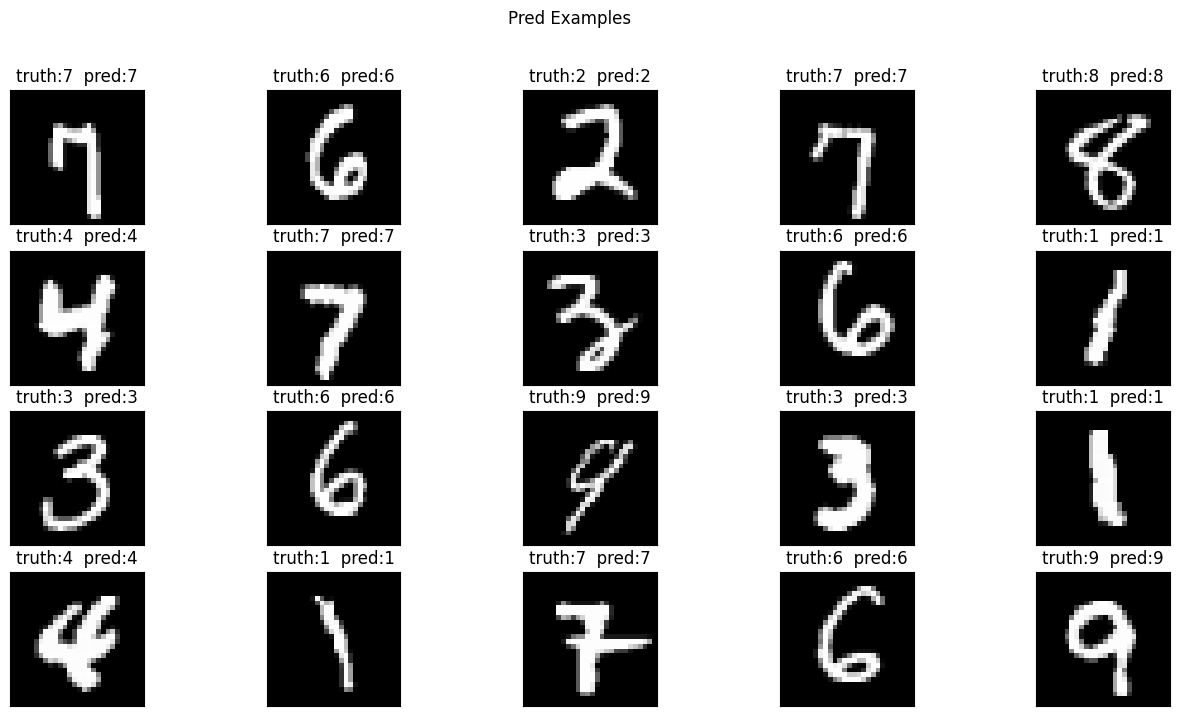

In [32]:
pred_labels = []
for img in img_test[80:100]:

    img = torch.tensor(img, dtype=torch.float32).to('cuda')
    img = img.reshape(1,1,28,28)

    pred = net(img)
    pred_label = torch.argmax(pred).item()
    pred_labels.append(pred_label)

# 可视化图形并保存结果
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(16, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(img_test[i+80].reshape(28, 28), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('truth:{}  pred:{}'.format(label_name[label_test[i+80]], label_name[pred_labels[i]]))
plt.suptitle('Pred Examples')
plt.savefig('./results/MNIST/{}/pred.png'.format(file_name))
plt.show()